In [1]:
import pycmap 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import signal
from numpy_ext import rolling_apply


In [2]:
# set up API 
api = pycmap.API(token='68fbf4b0-22f4-11ec-a2c9-a3d02432460d')

In [3]:
# get all cruises in the seaflow table
def get_cruise_names():
    my_df = api.get_var_coverage('tblSeaFlow', 'cruise') # time and space bounds
    df_cruise_names= api.space_time(
        table='tblSeaFlow',
        variable='cruise',
        dt1=my_df['Time_Min'].iloc[0],
        dt2=my_df['Time_Max'].iloc[0],
        lat1=my_df['Lat_Min'].iloc[0],
        lat2=my_df['Lat_Max'].iloc[0],
        lon1=my_df['Lon_Min'].iloc[0],
        lon2=my_df['Lon_Max'].iloc[0],
        depth1=0,
        depth2=50
        )
    cruise_names = pd.unique(df_cruise_names['cruise'])
    return cruise_names

cruise_names = get_cruise_names()
print(cruise_names)

['TN248' 'Tokyo_3' 'CN11ID' 'TN271' 'TN280' 'CN12ID' 'TN292' 'KN210-04'
 'CN13ID' 'KM1427' 'KM1502' 'KM1508' 'KM1510' 'KM1512' 'KM1513' 'KOK1512'
 'KOK1515' 'KM1518' 'KM1601' 'KM1602' 'KM1603' 'KOK1604' 'KOK1606'
 'KOK1607' 'KOK1608' 'KOK1609' 'MGL1704' 'KM1708' 'KM1709' 'KM1712'
 'KM1713' 'KM1717' 'KM1802' 'FK180310-1' 'FK180310-2' 'KOK1801' 'KOK1803'
 'KOK1804' 'KOK1806' 'KOK1807' 'KM1821' 'KM1823' 'KM1901' 'KM1903'
 'KM1906' 'KM1909' 'KM1912' 'KM1915' 'KM1917' 'SR1917']


In [4]:
# given a cruise name, return df of all samples joined with temp and PAR 
def get_cruise_data(cruise_name):
    # get slice of dataset that contains this cruise 
    df_cruise_bounds = api.cruise_bounds(cruise_name)
    dt1=df_cruise_bounds['dt1'].iloc[0]
    dt2=df_cruise_bounds['dt2'].iloc[0]
    lat1=df_cruise_bounds['lat1'].iloc[0] - 0.1
    lat2=df_cruise_bounds['lat2'].iloc[0] + 0.1
    lon1=df_cruise_bounds['lon1'].iloc[0] - 0.1
    lon2=df_cruise_bounds['lon2'].iloc[0] + 0.1
    # get prochloro data
    df_seaflow_prochloro_slice = api.space_time(
            table='tblSeaFlow',
            variable='abundance_prochloro',
            dt1=dt1,
            dt2=dt2,
            lat1=lat1,
            lat2=lat2,
            lon1=lon1,
            lon2=lon2,
            depth1=0,
            depth2=50
            )
    # get synecho data
    df_seaflow_synecho_slice = api.space_time(
        table='tblSeaFlow',
        variable='abundance_synecho',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    df_seaflow_cruise_slice = api.space_time(
        table='tblSeaFlow',
        variable='cruise',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # merge synecho column 
    df_seaflow_slice = pd.merge(df_seaflow_prochloro_slice, df_seaflow_synecho_slice)
    # merge cruise column 
    df_seaflow_slice = pd.merge(df_seaflow_slice, df_seaflow_cruise_slice)
    # get temp data
    df_temp_slice = api.space_time(
        table='tblCruise_Temperature',
        variable='temperature',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # get PAR data
    # PAR gathered from instrument on boat 
    df_par_slice = api.space_time(
        table='tblCruise_PAR',
        variable='par',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # merge temp data
    df_master = pd.merge(df_seaflow_slice, df_temp_slice)
    # merge par data
    # TODO: sometimes this is empty, use other PAR source??? 
    df_master = pd.merge(df_master, df_par_slice)
    # calculate distance from previous point, must be sorted by time 
    df_master.sort_values(by='time')
    # TODO: change lat/lon to km 
    # the great circle distance 
    delta_d = np.sqrt((df_master['lat'] - df_master['lat'].shift())**2 
                      + (df_master['lon'] - df_master['lon'].shift())**2)
    df_master['distance'] = delta_d.cumsum() # in terms of lat/lon distance 
    return df_master
    
    
cruise_name = 'MGL1704'
df_master = get_cruise_data(cruise_name)
df_master

,time,lat,lon,depth,abundance_prochloro,abundance_synecho,cruise,temperature,par,distance
0,2017-05-31T03:37:53,30.5946,-158.0008,5,134.035812,1.731893,MGL1704,21.8055,2434.830,NaN
1,2017-05-31T03:40:53,30.6021,-158.0008,5,133.959613,1.911870,MGL1704,21.6864,2441.498,0.007500
2,2017-05-31T03:43:54,30.6124,-158.0008,5,131.859051,1.694548,MGL1704,21.6394,2397.845,0.017800
3,2017-05-31T03:46:54,30.6213,-158.0009,5,133.075370,2.001192,MGL1704,21.5486,2408.900,0.026701
4,2017-05-31T03:49:54,30.6288,-158.0009,5,133.843666,2.019616,MGL1704,21.4427,2500.582,0.034201
...,...,...,...,...,...,...,...,...,...,...
5844,2017-06-13T17:52:24,22.0210,-157.6325,5,126.142839,0.917226,MGL1704,24.1820,1054.524,36.197034
5845,2017-06-13T17:55:24,22.0131,-157.6318,5,129.542666,0.832540,MGL1704,24.1682,1397.893,36.204965
5846,2017-06-13T17:58:24,22.0032,-157.6311,5,134.004131,1.095753,MGL1704,24.1561,1272.552,36.214890
5847,2017-06-13T18:01:24,21.9945,-157.6305,5,138.480508,0.923203,MGL1704,24.1441,1469.954,36.223610


<AxesSubplot:xlabel='distance'>

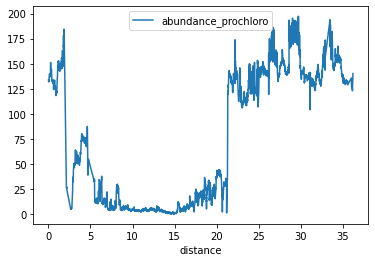

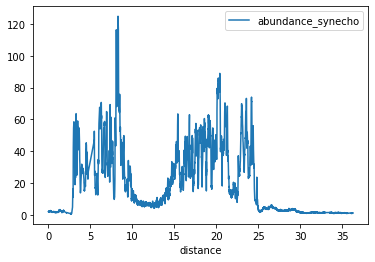

In [5]:
df_master.plot('distance','abundance_prochloro')
df_master.plot('distance', 'abundance_synecho')


In [7]:
# convolve with haar function 
ALPHA = 150

def haar_wavelet(points, alpha):
    result = []
    mid = points/2
    for i in range(points):
        if mid - alpha <= i < mid:
            result.append(-1/alpha)
        elif mid < i < mid + alpha:
            result.append(1/alpha)
        else:
            result.append(0)
    return result

def make_wavelet_plots(cruise_name):
    df_master = get_cruise_data(cruise_name)
    widths = [1, 50, 100, ALPHA]
    widths = [x+1 for x in range(ALPHA)]

    plt.title('Haar Wavelet Transform of Prochloroccus Abundance')
    plt.xlabel('distance (km)')
    plt.ylabel('alpha (km)')
    cwtmatr = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.show()

    plt.title('Haar Wavelet Transform of Synechococcus Abundance')
    plt.xlabel('distance (km)')
    plt.ylabel('alpha (km)')
    cwtmatr = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)
    plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.show()

    plt.title(f'Temperature for Cruise {cruise_name}')
    plt.xlabel('distance (km)')
    plt.ylabel('temperature (C)')
    plt.plot(df_master['distance'], df_master['temperature'])
    plt.show()

    plt.title(f'PAR for Cruise {cruise_name}')
    plt.xlabel('distance (km)')
    plt.ylabel('PAR (?)')
    plt.plot(df_master['distance'], df_master['par'])
    plt.show()


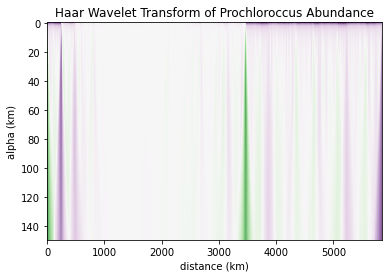

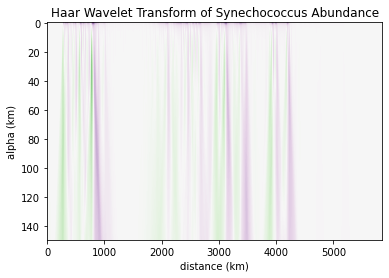

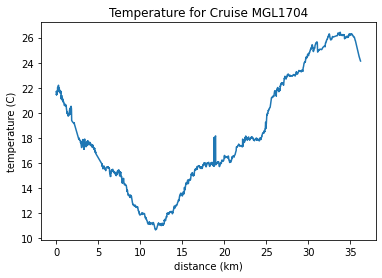

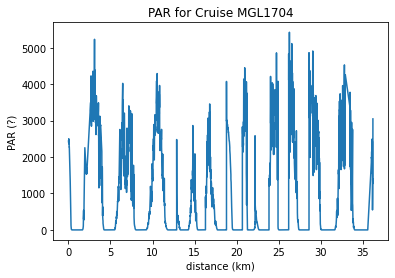

In [8]:
cruise_name = 'MGL1704'
make_wavelet_plots(cruise_name)

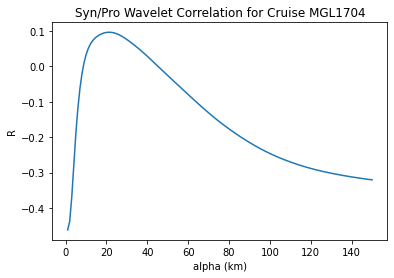

In [9]:
# plot R as a function of alpha between wavelets of pro and syn 
def plot_wavelet_corr_coefs(cruise_name, df_master = None, show_plot=True):
    if df_master is None:
        df_master = get_cruise_data(cruise_name)

    widths = [x+1 for x in range(ALPHA)]
    pro_wavelet = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    syn_wavelet = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)

    corrcoefs = []
    alpha = [] # width over which convolution was performed 
    for i in range(len(pro_wavelet)):
        alpha.append(i+1) #adding 1 because of zero indexing
        i_corrcoef_matrix = np.corrcoef(pro_wavelet[i], syn_wavelet[i])
        corrcoefs.append(i_corrcoef_matrix[0,1])
    if show_plot:
        plt.plot(alpha, corrcoefs)
        plt.title(f'Syn/Pro Wavelet Correlation for Cruise {cruise_name}')
        plt.xlabel('alpha (km)')
        plt.ylabel('R')
        plt.show()
    if not show_plot:
        return (alpha, corrcoefs)

plot_wavelet_corr_coefs(df_master['cruise'][0], df_master)

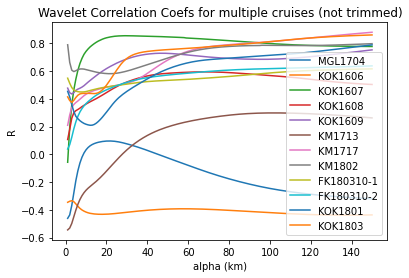

In [10]:
# Wavelet Correlation Coefs for multiple cruises (not trimmed)
cruise_names = get_cruise_names()[25:]
cruise_names = ['MGL1704', 'KOK1606', 'KOK1607', 'KOK1608', 'KOK1609','KM1713', 'KM1717', 'KM1802', 'FK180310-1', 'FK180310-2', \
                'KOK1801', 'KOK1803']

for cruise_name in cruise_names:
    alpha, corrcoefs = plot_wavelet_corr_coefs(cruise_name, show_plot=False)
    plt.plot(alpha, corrcoefs, label=cruise_name)
plt.legend()
plt.title('Wavelet Correlation Coefs for multiple cruises (not trimmed)')
plt.xlabel('alpha (km)')
plt.ylabel('R')
plt.show()

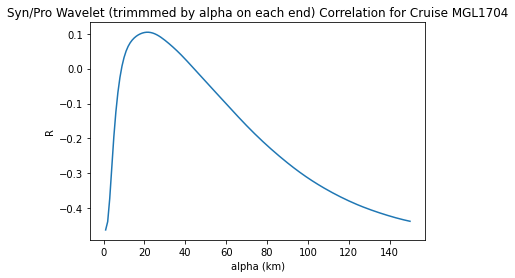

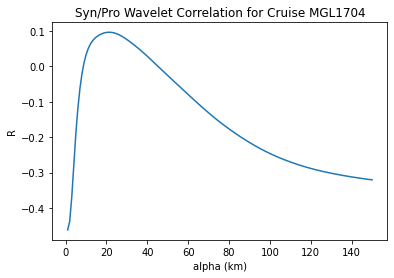

In [11]:
# trimmed the wavelet output by alpha on each end 
def plot_trimmed_wavelet_corr_coefs(cruise_name, df_master = None, show_plot=True):
    if df_master is None:
        df_master = get_cruise_data(cruise_name)

    widths = [x+1 for x in range(ALPHA)]
    pro_wavelet = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    syn_wavelet = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)
    
    corrcoefs = []
    alphas = [] # width over which convolution was performed 
    for i in range(len(pro_wavelet)):
        alpha = i + 1 #adding 1 because of zero indexing
        alphas.append(alpha)
        # trim the wavelet by alpha on each end 
        pro_wavelet_trimmed = pro_wavelet[i][alpha:len(pro_wavelet[i]) - alpha]
        syn_wavelet_trimmed = syn_wavelet[i][alpha:len(syn_wavelet[i]) - alpha]
        i_corrcoef_matrix = np.corrcoef(pro_wavelet_trimmed, syn_wavelet_trimmed)
        corrcoefs.append(i_corrcoef_matrix[0,1])
    if show_plot:
        plt.plot(alphas, corrcoefs)
        plt.title(f'Syn/Pro Wavelet (trimmmed by alpha on each end) Correlation for Cruise {cruise_name}')
        plt.xlabel('alpha (km)')
        plt.ylabel('R')
        plt.show()
    if not show_plot:
        return (alphas, corrcoefs)

plot_trimmed_wavelet_corr_coefs(df_master['cruise'][0], df_master)
plot_wavelet_corr_coefs(df_master['cruise'][0], df_master)

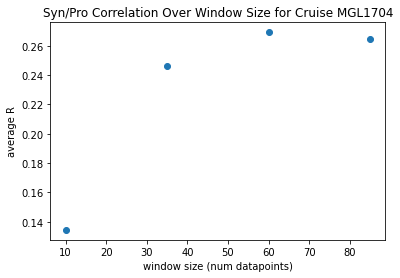

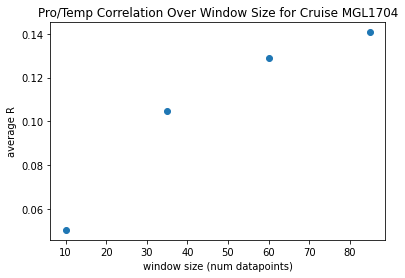

In [7]:
# Plot the avg correlation coefficient for a rolling window size

def get_corrcoef(col_1, col_2):
    corrcoef_matrix = np.corrcoef(col_1, col_2)
    return corrcoef_matrix[0,1]

def plot_rolling_window_corr_coefs(cruise_name, col_1, col_2, window_sizes=range(10,100,25), title="ADD TITLE"):
    avg_corrcoefs = []
    for window_size in window_sizes:
        # TODO: this can be parallelized 
        corrcoefs = rolling_apply(get_corrcoef, window_size, df_master[col_1], df_master[col_2], n_jobs=2)
        df_corrcoefs = pd.DataFrame({'corrcoefs': corrcoefs})
        avg_corrcoefs.append(df_corrcoefs.mean())
    
    plt.scatter(window_sizes, avg_corrcoefs)
    plt.title(title)
    plt.xlabel('window size (num datapoints)')
    plt.ylabel('average R')
    plt.show()
    plt.show()
    
pro = 'abundance_prochloro'
syn = 'abundance_synecho'
cruise_name = df_master['cruise'][0]
plot_rolling_window_corr_coefs(cruise_name, pro, syn, title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_rolling_window_corr_coefs(cruise_name, pro, 'temperature', title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')




x 30141
y 30141


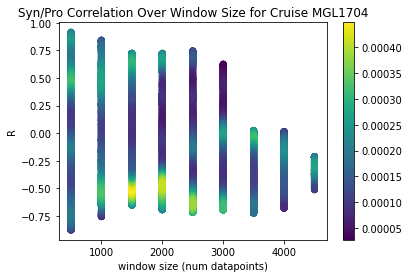

x 30141
y 30141


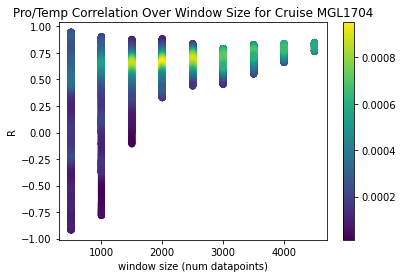

In [9]:
# Plot the heatmap of correlation coefficients for a rolling window size 

from scipy.stats import gaussian_kde

def plot_corr_coefs_heatmap(cruise_name, col_1, col_2, window_sizes=range(1,5001,500), title="ADD TITLE"):
    avg_corrcoefs = []
    x = []
    y = []
    for window_size in window_sizes:
        # TODO: this can be parallelized 
        corrcoefs = rolling_apply(get_corrcoef, window_size, df_master[col_1], df_master[col_2], n_jobs=2)
        # drop all NaNs from corrcoefs
        corrcoefs = corrcoefs[np.logical_not(np.isnan(corrcoefs))]
        x.append([window_size]*len(corrcoefs))
        y.append(corrcoefs.copy())

    # flatten the lists
    x = list(np.concatenate(x).flat)
    y = list(np.concatenate(y).flat)
    print('x', len(x))
    print('y', len(y))
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
#     idx = z.argsort()
#     x, y, z = x[idx], y[idx], z[idx]
    
    plt.scatter(x, y, c=z)
    # TODO: colorbar label?? 
    plt.colorbar()
    #plt.hist2d(x, flat_y, cmap=plt.cm.jet)
    plt.title(title)
    plt.xlabel('window size (num datapoints)')
    plt.ylabel('R')
    plt.show()
    plt.show()
    
pro = 'abundance_prochloro'
syn = 'abundance_synecho'
cruise_name = df_master['cruise'][0]
plot_corr_coefs_heatmap(cruise_name, pro, syn, title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


x 164101
y 164101


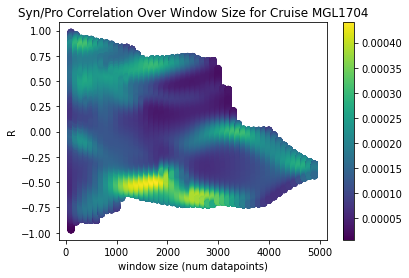

x 164101
y 164101


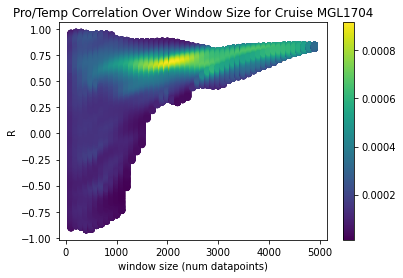

In [10]:
plot_corr_coefs_heatmap(cruise_name, pro, syn, window_sizes=range(1,5001,100), title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,5001,100),  title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


x 331551
y 331551


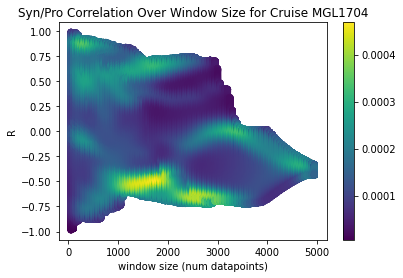

x 331551
y 331551


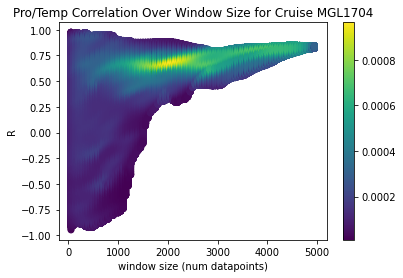

In [11]:
plot_corr_coefs_heatmap(cruise_name, pro, syn, window_sizes=range(1,5001,50), title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,5001,50),  title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


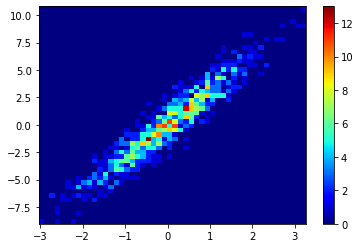

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# fake data:
a = np.random.normal(size=1000)
b = a*3 + np.random.normal(size=1000)

plt.hist2d(a, b, (50, 50), cmap=plt.cm.jet)
plt.colorbar()

In [13]:
df_master.head()

,time,lat,lon,depth,abundance_prochloro,abundance_synecho,cruise,temperature,par,distance
0,2017-05-31T03:37:53,30.5946,-158.0008,5,134.035812,1.731893,MGL1704,21.8055,2434.830,NaN
1,2017-05-31T03:40:53,30.6021,-158.0008,5,133.959613,1.911870,MGL1704,21.6864,2441.498,0.007500
2,2017-05-31T03:43:54,30.6124,-158.0008,5,131.859051,1.694548,MGL1704,21.6394,2397.845,0.017800
3,2017-05-31T03:46:54,30.6213,-158.0009,5,133.075370,2.001192,MGL1704,21.5486,2408.900,0.026701
4,2017-05-31T03:49:54,30.6288,-158.0009,5,133.843666,2.019616,MGL1704,21.4427,2500.582,0.034201


In [14]:
# going to want to trim the output by alpha or 2 alpha 

# correlation between syn and pro wavelets
# plot R as a function of alpha between pro and syn 
# for each cruise 


# testing: do pro vs T 

trying to get TN248...
blah :(
got it
trying to get Tokyo_3...
blah :(
got it
trying to get CN11ID...
blah :(
got it
trying to get TN271...
got it
trying to get TN280...
got it
trying to get CN12ID...
blah :(
got it
trying to get TN292...
blah :(
got it
trying to get KN210-04...
got it
trying to get CN13ID...
blah :(
got it
trying to get KM1427...
got it
trying to get KM1502...
got it
trying to get KM1508...
got it
trying to get KM1510...
got it
trying to get KM1512...
got it
trying to get KM1513...
got it
trying to get KOK1512...
got it
trying to get KOK1515...
got it
trying to get KM1518...
got it
trying to get KM1601...
got it
trying to get KM1602...
got it
trying to get KM1603...
got it
trying to get KOK1604...
got it
trying to get KOK1606...
got it
trying to get KOK1607...
got it
trying to get KOK1608...
got it
trying to get KOK1609...
got it
trying to get MGL1704...
got it
trying to get KM1708...
got it
trying to get KM1709...
got it
trying to get KM1712...
got it
trying to get K

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


blah :(
got it
trying to get KM1821...
got it
trying to get KM1823...
got it
trying to get KM1901...
got it
trying to get KM1903...
got it
trying to get KM1906...
got it
trying to get KM1909...
blah :(
got it
trying to get KM1912...
blah :(
got it
trying to get KM1915...
blah :(
got it
trying to get KM1917...
blah :(
got it
trying to get SR1917...
blah :(
got it


ValueError: x and y must be the same size

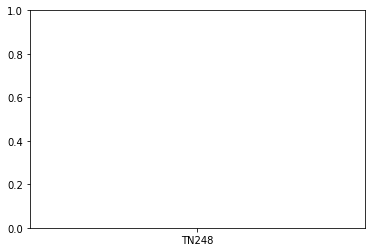

In [15]:
import traceback
import logging

# Get R between Pro and Temp for each cruise
corr_coefs = []
cruises = get_cruise_names()
for cruise in cruises:
    try:
        print(f'trying to get {cruise}...')
        df_master = get_cruise_data(cruise)
    except Exception as e:
        print('blah :(')
        pass
    print("got it")
    corr_coefs.append(np.corrcoef(df_master[pro], df_master['temperature']))
    
plt.scatter(cruises, corr_coefs)    
plt.show()

In [ ]:
# TODO: make list of "working" cruises

